In [35]:
#!/usr/bin/env python
# coding: utf-8

# ### 使用NN进行预测
# ### Score = ？

# In[1]:
# lambda函数，可以接受多个参数，返回一个表达式的值

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 数据加载

test = pd.read_csv('./test1.csv')
train = pd.read_csv('./train.csv')
test = test.iloc[:, 1:]
train = train.iloc[:, 1:]


# ##### Object类型： lan, os, osv, version, fea_hash
# ##### 有缺失值的字段： lan, osv

# In[2]:


# ['os', 'osv', 'lan', 'sid’]
features = train.columns.tolist()
features.remove('label')
print(features)


# In[3]:


for feature in features:
    print(feature, train[feature].nunique())


# In[4]:


# 对osv进行数据清洗
def osv_trans(x):
    x = str(x).replace('Android_', '').replace('Android ', '').replace('W', '')
    if str(x).find('.')>0:
        temp_index1 = x.find('.')
        if x.find(' ')>0:
            temp_index2 = x.find(' ')
        else:
            temp_index2 = len(x)

        if x.find('-')>0:
            temp_index2 = x.find('-')
            
        result = x[0:temp_index1] + '.' + x[temp_index1+1:temp_index2].replace('.', '')
        try:
            return float(result)
        except:
            print(x+'#########')
            return 0
    try:
        return float(x)
    except:
        print(x+'#########')
        return 0
#train['osv'] => LabelEncoder ?
# 采用众数，进行缺失值的填充
train['osv'].fillna('8.1.0', inplace=True)
# 数据清洗
train['osv'] = train['osv'].apply(osv_trans)

# 采用众数，进行缺失值的填充
test['osv'].fillna('8.1.0', inplace=True)
# 数据清洗
test['osv'] = test['osv'].apply(osv_trans)


# In[5]:


#train['os'].value_counts()
train['lan'].value_counts()
#lan_map = {'zh-CN': 1, }
train['lan'].value_counts().index
lan_map = {'zh-CN': 1, 'zh_CN':2, 'Zh-CN': 3, 'zh-cn': 4, 'zh_CN_#Hans':5, 'zh': 6, 'ZH': 7, 'cn':8, 'CN':9, 'zh-HK': 10, 'tw': 11, 'TW': 12, 'zh-TW': 13,             'zh-MO':14, 'en':15, 'en-GB': 16, 'en-US': 17, 'ko': 18, 'ja': 19, 'it': 20, 'mi':21} 
train['lan'] = train['lan'].map(lan_map)
test['lan'] = test['lan'].map(lan_map)
test['lan'].value_counts()


# In[6]:


# 对于有缺失的lan 设置为22
train['lan'].fillna(22, inplace=True)
test['lan'].fillna(22, inplace=True)


# In[7]:


remove_list = ['os', 'sid']
col = features
for i in remove_list:
    col.remove(i)
col


# In[8]:


#train['timestamp'].value_counts()
#train['timestamp'] = pd.to_datetime(train['timestamp'])
#train['timestamp']
from datetime import datetime

# lambda 是一句话函数，匿名函数
train['timestamp'] = train['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
#1559892728241.7212
#1559871800477.1477
#1625493942.538375
#import time
#time.time()
test['timestamp'] = test['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
test['timestamp']


# In[9]:


def version_trans(x):
    if x=='V3':
        return 3
    if x=='v1':
        return 1
    if x=='P_Final_6':
        return 6
    if x=='V6':
        return 6
    if x=='GA3':
        return 3
    if x=='GA2':
        return 2
    if x=='V2':
        return 2
    if x=='50':
        return 5
    return int(x)
train['version'] = train['version'].apply(version_trans)
test['version'] = test['version'].apply(version_trans)
train['version'] = train['version'].astype('int')
test['version'] = test['version'].astype('int')


# In[10]:


# 特征筛选
features = train[col]
# 构造fea_hash_len特征
features['fea_hash_len'] = features['fea_hash'].map(lambda x: len(str(x)))
features['fea1_hash_len'] = features['fea1_hash'].map(lambda x: len(str(x)))
# Thinking：为什么将很大的，很长的fea_hash化为0？
# 如果fea_hash很长，都归为0，否则为自己的本身
features['fea_hash'] = features['fea_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
features['fea1_hash'] = features['fea1_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
features

test_features = test[col]
# 构造fea_hash_len特征
test_features['fea_hash_len'] = test_features['fea_hash'].map(lambda x: len(str(x)))
test_features['fea1_hash_len'] = test_features['fea1_hash'].map(lambda x: len(str(x)))
# Thinking：为什么将很大的，很长的fea_hash化为0？
# 如果fea_hash很长，都归为0，否则为自己的本身
test_features['fea_hash'] = test_features['fea_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
test_features['fea1_hash'] = test_features['fea1_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
test_features


# In[11]:


"""
train_set = set()
for x in train['sid'].value_counts().index.tolist():
    train_set.add(x)
#train_set.add(train['sid'].value_counts().index.tolist())
train_set
test_set = set()
for x in test['sid'].value_counts().index.tolist():
    test_set.add(x)
# test_set.add(test['sid'].value_counts().index.tolist())
# test['sid'].value_counts().index.tolist()
train_set & test_set # 没有重复值
"""


# In[11]:


# 对训练集的timestamp提取时间多尺度

# 使用to_datetime进行日期类型转换
# 创建时间戳索引
temp = pd.DatetimeIndex(features['timestamp'])
features['year'] = temp.year
features['month'] = temp.month
features['day'] = temp.day
features['week_day'] = temp.weekday #星期几
features['hour'] = temp.hour
features['minute'] = temp.minute

# 求时间的diff
start_time = features['timestamp'].min()
features['time_diff'] = features['timestamp'] - start_time
features['time_diff'] = features['time_diff'].dt.days + features['time_diff'].dt.seconds/3600/24
features[['timestamp', 'year', 'month', 'day', 'week_day', 'hour', 'minute', 'time_diff']]

# 创建时间戳索引
temp = pd.DatetimeIndex(test_features['timestamp'])
test_features['year'] = temp.year
test_features['month'] = temp.month
test_features['day'] = temp.day
test_features['week_day'] = temp.weekday #星期几
test_features['hour'] = temp.hour
test_features['minute'] = temp.minute

# 求时间的diff
#start_time = features['timestamp'].min()
test_features['time_diff'] = test_features['timestamp'] - start_time
test_features['time_diff'] = test_features['time_diff'].dt.days + test_features['time_diff'].dt.seconds/3600/24
#test_features[['timestamp', 'year', 'month', 'day', 'week_day', 'hour', 'minute', 'time_diff']]
test_features['time_diff']


# In[12]:


#test['version'].value_counts()
#features['version'].value_counts()
features['dev_height'].value_counts()
features['dev_width'].value_counts()
# 构造面积特征
features['dev_area'] = features['dev_height'] * features['dev_width']
test_features['dev_area'] = test_features['dev_height'] * test_features['dev_width']


# In[13]:


"""
Thinking：是否可以利用 dev_ppi 和 dev_area构造新特征
features['dev_ppi'].value_counts()
features['dev_area'].astype('float') / features['dev_ppi'].astype('float')
"""
#features['ntt'].value_counts()
features['carrier'].value_counts()
features['package'].value_counts()
# version - osv APP版本与操作系统版本差
features['osv'].value_counts()
features['version_osv'] = features['osv'] - features['version']
test_features['version_osv'] = test_features['osv'] - test_features['version']


# In[14]:


features = features.drop(['timestamp'], axis=1)
test_features = test_features.drop(['timestamp'], axis=1)


# In[16]:




['android_id', 'apptype', 'carrier', 'dev_height', 'dev_ppi', 'dev_width', 'lan', 'media_id', 'ntt', 'os', 'osv', 'package', 'sid', 'timestamp', 'version', 'fea_hash', 'location', 'fea1_hash', 'cus_type']
android_id 362258
apptype 89
carrier 5
dev_height 798
dev_ppi 92
dev_width 346
lan 21
media_id 284
ntt 8
os 2
osv 154
package 1950
sid 500000
timestamp 500000
version 22
fea_hash 402980
location 332
fea1_hash 4959
cus_type 58
f073b_changxiang_v01_b1b8_20180915#########
%E6%B1%9F%E7%81%B5OS+5.0#########
GIONEE_YNGA#########


In [36]:
features

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,lan,media_id,ntt,osv,...,fea1_hash_len,year,month,day,week_day,hour,minute,time_diff,dev_area,version_osv
0,316361,1199,46000.0,0.0,0.0,0.0,22.0,104,6.0,9.00,...,10,2019,6,7,4,15,32,4.647303,0.0,1.00
1,135939,893,0.0,0.0,0.0,0.0,22.0,19,6.0,8.10,...,10,2019,6,8,5,19,40,5.819664,0.0,4.10
2,399254,821,0.0,760.0,0.0,360.0,22.0,559,0.0,8.10,...,9,2019,6,6,3,23,58,3.998796,273600.0,8.10
3,68983,1004,46000.0,2214.0,0.0,1080.0,22.0,129,2.0,8.10,...,10,2019,6,9,6,8,59,6.374722,2391120.0,8.10
4,288999,1076,46000.0,2280.0,0.0,1080.0,1.0,64,2.0,8.00,...,10,2019,6,7,4,8,28,4.353009,2462400.0,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,392477,1028,46000.0,1920.0,3.0,1080.0,1.0,144,6.0,7.12,...,9,2019,6,6,3,23,14,3.968252,2073600.0,0.12
499996,346134,1001,0.0,1424.0,0.0,720.0,22.0,29,2.0,8.10,...,10,2019,6,6,3,17,40,3.736713,1025280.0,5.10
499997,499635,761,46000.0,1280.0,0.0,720.0,22.0,54,6.0,6.01,...,10,2019,6,5,2,3,14,2.135370,921600.0,6.01
499998,239786,917,46001.0,960.0,0.0,540.0,2.0,109,2.0,5.11,...,10,2019,6,7,4,0,59,4.041273,518400.0,5.11


In [37]:
# 特征归一化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features1 = scaler.fit_transform(features)
test_features1 = scaler.transform(test_features)

In [38]:
features.shape

(500000, 27)

In [39]:
features1.shape

(500000, 27)

In [40]:
features1

array([[ 0.23543652,  1.64675959,  0.3862169 , ...,  0.46694726,
        -1.18201628, -0.02790324],
       [-0.53686523, -0.72613877, -2.58905469, ...,  1.06961288,
        -1.18201628, -0.01990146],
       [ 0.59026249, -1.2844678 , -2.58905469, ...,  0.13357486,
        -0.92262208, -0.00957659],
       ...,
       [ 1.01994635, -1.74974198,  0.3862169 , ..., -0.82434052,
        -0.30826739, -0.01497134],
       [-0.09234505, -0.54002909,  0.38628158, ...,  0.15541057,
        -0.69053253, -0.01729443],
       [ 0.03925984, -0.44697426,  0.3862169 , ...,  0.63852716,
         0.90678965, -0.02248268]])

In [41]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [42]:
type(features1)

numpy.ndarray

In [43]:
type(train['label'])

pandas.core.series.Series

In [44]:
train['label']

0         1
1         1
2         1
3         0
4         1
         ..
499995    1
499996    0
499997    0
499998    0
499999    1
Name: label, Length: 500000, dtype: int64

In [45]:
train['label'] = train['label'].to_numpy()

In [46]:
type(train['label'])

pandas.core.series.Series

In [47]:
features1

array([[ 0.23543652,  1.64675959,  0.3862169 , ...,  0.46694726,
        -1.18201628, -0.02790324],
       [-0.53686523, -0.72613877, -2.58905469, ...,  1.06961288,
        -1.18201628, -0.01990146],
       [ 0.59026249, -1.2844678 , -2.58905469, ...,  0.13357486,
        -0.92262208, -0.00957659],
       ...,
       [ 1.01994635, -1.74974198,  0.3862169 , ..., -0.82434052,
        -0.30826739, -0.01497134],
       [-0.09234505, -0.54002909,  0.38628158, ...,  0.15541057,
        -0.69053253, -0.01729443],
       [ 0.03925984, -0.44697426,  0.3862169 , ...,  0.63852716,
         0.90678965, -0.02248268]])

In [48]:
feature

'cus_type'

In [49]:
adam = Adam(lr=0.001)
# 搭建模型 加上正则化项
# 工程上 神经网络容易过拟合 => 因为神经网络的参数量大
model = keras.Sequential([
    keras.layers.Dense(250, activation='relu', input_shape=[len(features.columns)], kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.02),
    keras.layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.02),
    keras.layers.Dense(50, kernel_regularizer=regularizers.l2(0.001)), 
    keras.layers.Dropout(0.02),
    keras.layers.Dense(25, kernel_regularizer=regularizers.l2(0.001)), 
    keras.layers.Dropout(0.02),
    keras.layers.Dense(1, activation='sigmoid') # 需要改写成sigmoid
])
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam)
# batch_size 根据情况而选择，epochs可以一开始小一些
# model.fit(features1, train['label'].to_numpy(), batch_size=10240, epochs=30)
history = model.fit(features1, train['label'].to_numpy(), batch_size=10240, epochs=20)
# 如果有验证集，可以进行设置
#model.fit(features1, labels, validation_data=(test_fea1, test_ans), batch_size=10240, epochs=50)



Train on 500000 samples
Epoch 1/20
500000/500000 [==============================] - 9s 18us/sample - loss: 0.8273 - accuracy: 0.6974
Epoch 2/20
500000/500000 [==============================] - 7s 15us/sample - loss: 0.6945 - accuracy: 0.7613
Epoch 3/20
500000/500000 [==============================] - 7s 14us/sample - loss: 0.6209 - accuracy: 0.7818
Epoch 4/20
500000/500000 [==============================] - 7s 14us/sample - loss: 0.5664 - accuracy: 0.7966
Epoch 5/20
500000/500000 [==============================] - 7s 14us/sample - loss: 0.5281 - accuracy: 0.8046
Epoch 6/20
500000/500000 [==============================] - 6s 13us/sample - loss: 0.5007 - accuracy: 0.8125
Epoch 7/20
500000/500000 [==============================] - 7s 13us/sample - loss: 0.4815 - accuracy: 0.8199
Epoch 8/20
500000/500000 [==============================] - 6s 13us/sample - loss: 0.4681 - accuracy: 0.8239
Epoch 9/20
500000/500000 [==============================] - 7s 13us/sample - loss: 0.4581 - accuracy: 0.

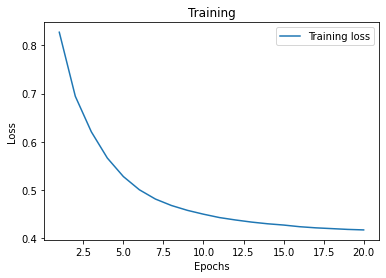

In [50]:
# example1
# history = model.fit(train_x, labels_x, epochs=20, batch_size=32, validation_data=(train_y, labels_y))
loss = history.history['loss']
# val_loss = history.history['val_loss']
import matplotlib.pyplot as plt
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
# plt.plot(epochs, label='Validation loss')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 数据加载
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test1.csv')
test = test.iloc[:, 1:]
train = train.iloc[:, 1:]
train


# ##### Object类型： lan, os, osv, version, fea_hash
# ##### 有缺失值的字段： lan, osv

# In[2]:


# ['os', 'osv', 'lan', 'sid’]
features = train.columns.tolist()
features.remove('label')
print(features)


# In[3]:


for feature in features:
    print(feature, train[feature].nunique())


# In[4]:


# 对osv进行数据清洗
def osv_trans(x):
    x = str(x).replace('Android_', '').replace('Android ', '').replace('W', '')
    if str(x).find('.')>0:
        temp_index1 = x.find('.')
        if x.find(' ')>0:
            temp_index2 = x.find(' ')
        else:
            temp_index2 = len(x)

        if x.find('-')>0:
            temp_index2 = x.find('-')
            
        result = x[0:temp_index1] + '.' + x[temp_index1+1:temp_index2].replace('.', '')
        try:
            return float(result)
        except:
            print(x+'#########')
            return 0
    try:
        return float(x)
    except:
        print(x+'#########')
        return 0
#train['osv'] => LabelEncoder ?
# 采用众数，进行缺失值的填充
train['osv'].fillna('8.1.0', inplace=True)
# 数据清洗
train['osv'] = train['osv'].apply(osv_trans)

# 采用众数，进行缺失值的填充
test['osv'].fillna('8.1.0', inplace=True)
# 数据清洗
test['osv'] = test['osv'].apply(osv_trans)


# In[5]:


#train['os'].value_counts()
train['lan'].value_counts()
#lan_map = {'zh-CN': 1, }
train['lan'].value_counts().index
lan_map = {'zh-CN': 1, 'zh_CN':2, 'Zh-CN': 3, 'zh-cn': 4, 'zh_CN_#Hans':5, 'zh': 6, 'ZH': 7, 'cn':8, 'CN':9, 'zh-HK': 10, 'tw': 11, 'TW': 12, 'zh-TW': 13,             'zh-MO':14, 'en':15, 'en-GB': 16, 'en-US': 17, 'ko': 18, 'ja': 19, 'it': 20, 'mi':21} 
train['lan'] = train['lan'].map(lan_map)
test['lan'] = test['lan'].map(lan_map)
test['lan'].value_counts()


# In[6]:


# 对于有缺失的lan 设置为22
train['lan'].fillna(22, inplace=True)
test['lan'].fillna(22, inplace=True)


# In[7]:


remove_list = ['os', 'sid']
col = features
for i in remove_list:
    col.remove(i)
col


# In[8]:


#train['timestamp'].value_counts()
#train['timestamp'] = pd.to_datetime(train['timestamp'])
#train['timestamp']
from datetime import datetime

# lambda 是一句话函数，匿名函数
train['timestamp'] = train['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
#1559892728241.7212
#1559871800477.1477
#1625493942.538375
#import time
#time.time()
test['timestamp'] = test['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
test['timestamp']


# In[9]:


def version_trans(x):
    if x=='V3':
        return 3
    if x=='v1':
        return 1
    if x=='P_Final_6':
        return 6
    if x=='V6':
        return 6
    if x=='GA3':
        return 3
    if x=='GA2':
        return 2
    if x=='V2':
        return 2
    if x=='50':
        return 5
    return int(x)
train['version'] = train['version'].apply(version_trans)
test['version'] = test['version'].apply(version_trans)
train['version'] = train['version'].astype('int')
test['version'] = test['version'].astype('int')


# In[10]:


# 特征筛选
features = train[col]
# 构造fea_hash_len特征
features['fea_hash_len'] = features['fea_hash'].map(lambda x: len(str(x)))
features['fea1_hash_len'] = features['fea1_hash'].map(lambda x: len(str(x)))
# Thinking：为什么将很大的，很长的fea_hash化为0？
# 如果fea_hash很长，都归为0，否则为自己的本身
features['fea_hash'] = features['fea_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
features['fea1_hash'] = features['fea1_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
features

test_features = test[col]
# 构造fea_hash_len特征
test_features['fea_hash_len'] = test_features['fea_hash'].map(lambda x: len(str(x)))
test_features['fea1_hash_len'] = test_features['fea1_hash'].map(lambda x: len(str(x)))
# Thinking：为什么将很大的，很长的fea_hash化为0？
# 如果fea_hash很长，都归为0，否则为自己的本身
test_features['fea_hash'] = test_features['fea_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
test_features['fea1_hash'] = test_features['fea1_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
test_features


# In[11]:


"""
train_set = set()
for x in train['sid'].value_counts().index.tolist():
    train_set.add(x)
#train_set.add(train['sid'].value_counts().index.tolist())
train_set
test_set = set()
for x in test['sid'].value_counts().index.tolist():
    test_set.add(x)
# test_set.add(test['sid'].value_counts().index.tolist())
# test['sid'].value_counts().index.tolist()
train_set & test_set # 没有重复值
"""


# In[11]:


# 对训练集的timestamp提取时间多尺度

# 使用to_datetime进行日期类型转换
# 创建时间戳索引
temp = pd.DatetimeIndex(features['timestamp'])
features['year'] = temp.year
features['month'] = temp.month
features['day'] = temp.day
features['week_day'] = temp.weekday #星期几
features['hour'] = temp.hour
features['minute'] = temp.minute

# 求时间的diff
start_time = features['timestamp'].min()
features['time_diff'] = features['timestamp'] - start_time
features['time_diff'] = features['time_diff'].dt.days + features['time_diff'].dt.seconds/3600/24
features[['timestamp', 'year', 'month', 'day', 'week_day', 'hour', 'minute', 'time_diff']]

# 创建时间戳索引
temp = pd.DatetimeIndex(test_features['timestamp'])
test_features['year'] = temp.year
test_features['month'] = temp.month
test_features['day'] = temp.day
test_features['week_day'] = temp.weekday #星期几
test_features['hour'] = temp.hour
test_features['minute'] = temp.minute

# 求时间的diff
#start_time = features['timestamp'].min()
test_features['time_diff'] = test_features['timestamp'] - start_time
test_features['time_diff'] = test_features['time_diff'].dt.days + test_features['time_diff'].dt.seconds/3600/24
#test_features[['timestamp', 'year', 'month', 'day', 'week_day', 'hour', 'minute', 'time_diff']]
test_features['time_diff']


# In[12]:


#test['version'].value_counts()
#features['version'].value_counts()
features['dev_height'].value_counts()
features['dev_width'].value_counts()
# 构造面积特征
features['dev_area'] = features['dev_height'] * features['dev_width']
test_features['dev_area'] = test_features['dev_height'] * test_features['dev_width']


# In[13]:


"""
Thinking：是否可以利用 dev_ppi 和 dev_area构造新特征
features['dev_ppi'].value_counts()
features['dev_area'].astype('float') / features['dev_ppi'].astype('float')
"""
#features['ntt'].value_counts()
features['carrier'].value_counts()
features['package'].value_counts()
# version - osv APP版本与操作系统版本差
features['osv'].value_counts()
features['version_osv'] = features['osv'] - features['version']
test_features['version_osv'] = test_features['osv'] - test_features['version']


# In[14]:


features = features.drop(['timestamp'], axis=1)
test_features = test_features.drop(['timestamp'], axis=1)


# In[16]:


# 特征归一化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features1 = scaler.fit_transform(features)
test_features1 = scaler.transform(test_features)


# In[ ]:


# SGD， Adam, tanh, 
# Adamw 在Adam之后进行了改进 => 用更少的epochs 带来更好的效果


# In[45]:


# 使用神经网络进行训练
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

adam = Adam(lr=0.001)
# 搭建模型 加上正则化项
# 工程上 神经网络容易过拟合 => 因为神经网络的参数量大
model = keras.Sequential([
    keras.layers.Dense(250, activation='relu', input_shape=[len(features.columns)], kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.02),
    keras.layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.02),
    keras.layers.Dense(50, kernel_regularizer=regularizers.l2(0.001)), 
    keras.layers.Dropout(0.02),
    keras.layers.Dense(25, kernel_regularizer=regularizers.l2(0.001)), 
    keras.layers.Dropout(0.02),
    keras.layers.Dense(1, activation='sigmoid') # 需要改写成sigmoid
])
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam)
# batch_size 根据情况而选择，epochs可以一开始小一些
hostory = model.fit(features1, train['label'].to_numpy(), batch_size=10240, epochs=10)

['android_id', 'apptype', 'carrier', 'dev_height', 'dev_ppi', 'dev_width', 'lan', 'media_id', 'ntt', 'os', 'osv', 'package', 'sid', 'timestamp', 'version', 'fea_hash', 'location', 'fea1_hash', 'cus_type']
android_id 362258
apptype 89
carrier 5
dev_height 798
dev_ppi 92
dev_width 346
lan 21
media_id 284
ntt 8
os 2
osv 154
package 1950
sid 500000
timestamp 500000
version 22
fea_hash 402980
location 332
fea1_hash 4959
cus_type 58
f073b_changxiang_v01_b1b8_20180915#########
%E6%B1%9F%E7%81%B5OS+5.0#########
GIONEE_YNGA#########
Train on 500000 samples
Epoch 1/10
500000/500000 [==============================] - 8s 16us/sample - loss: 0.8062 - accuracy: 0.7103
Epoch 2/10
500000/500000 [==============================] - 6s 13us/sample - loss: 0.6749 - accuracy: 0.7677
Epoch 3/10
500000/500000 [==============================] - 6s 12us/sample - loss: 0.5997 - accuracy: 0.7863
Epoch 4/10
500000/500000 [==============================] - 7s 13us/sample - loss: 0.5489 - accuracy: 0.8003
Epoch 5/10

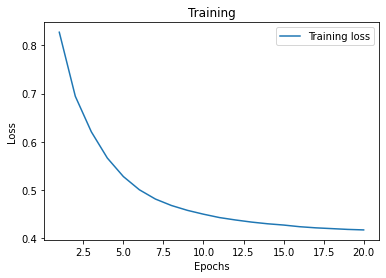

In [52]:
# example1
# history = model.fit(train_x, labels_x, epochs=20, batch_size=32, validation_data=(train_y, labels_y))
loss = history.history['loss']
# val_loss = history.history['val_loss']
import matplotlib.pyplot as plt
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
# plt.plot(epochs, label='Validation loss')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['AUC'])
            
history = model.fit(features1, train['label'].to_numpy(), batch_size=10240,
                    epochs= 10,
                    validation_split=0.2 #分割一部分训练数据用于验证
                   )
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['AUC']
val_auc = history.history['val_AUC']


Train on 400000 samples, validate on 100000 samples
Epoch 1/10
400000/400000 [==============================] - 9s 22us/sample - loss: 0.4475 - AUC: 0.8997 - val_loss: 0.4337 - val_AUC: 0.9067
Epoch 2/10
400000/400000 [==============================] - 7s 18us/sample - loss: 0.4371 - AUC: 0.9036 - val_loss: 0.4320 - val_AUC: 0.9070
Epoch 3/10
400000/400000 [==============================] - 8s 19us/sample - loss: 0.4342 - AUC: 0.9038 - val_loss: 0.4269 - val_AUC: 0.9073
Epoch 4/10
400000/400000 [==============================] - 8s 19us/sample - loss: 0.4310 - AUC: 0.9046 - val_loss: 0.4263 - val_AUC: 0.9064
Epoch 5/10
400000/400000 [==============================] - 8s 19us/sample - loss: 0.4287 - AUC: 0.9050 - val_loss: 0.4229 - val_AUC: 0.9078
Epoch 6/10
400000/400000 [==============================] - 10s 25us/sample - loss: 0.4260 - AUC: 0.9058 - val_loss: 0.4225 - val_AUC: 0.9077
Epoch 7/10
400000/400000 [==============================] - 9s 23us/sample - loss: 0.4249 - AUC: 0.90

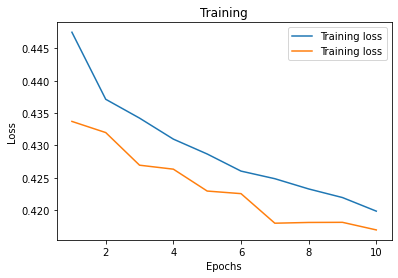

In [54]:

# train_loss = history.history['loss']
# val_loss = history.history['val_loss']
# train_auc = history.history['AUC']
# val_auc = history.history['val_AUC']




# val_loss = history.history['val_loss']
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss)+1)
plt.plot(epochs,train_loss, label='Training loss')
plt.plot(epochs,val_loss, label='Training loss')
# plt.plot(epochs,train_auc, label='Training loss')
# plt.plot(epochs,val_auc, label='Training loss')
# plt.plot(epochs, label='Validation loss')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()